# 配送計画問題
参考:[Pythonではじめる数理最適化](https://www.ohmsha.co.jp/book/9784274227356/)

## 実装と数値実験
### 問題設定・パラメータの定義とデータ確認
まず、必要なライブラリをインストールする

In [1]:
from IPython.display import display
import numpy as np
import pandas as pd
import os, sys
import matplotlib.pyplot as plt
import matplotlib as mpl
import pulp
from itertools import product, combinations_with_replacement
from joblib import Parallel, delayed

問題設定に必要な数値群を設定する。

In [2]:
np.random.seed(32)
num_places = 10  # 地点の数
num_days = 30  # 計画の対象日数
num_requests = 120  # 荷物の数

mean_travel_time_to_destinations = 100  # 自社から平均的に100分程度距離に配達先候補があるとしてデータを作る．
H_regular = 8*60  # 8時間が定時労働
H_max_overtime = 3*60  # 残業3時間まで
c = 3000//60  # 残業による経費60分 3000円
W = 4000  # 4 トントラックを利用
delivery_outsourcing_unit_cost = 4600  # 100kg あたり4600円の配送費用
delivery_time_window = 3  # 連続する3日が配達可能な候補日となる．
avg_weight = 1000  # 荷物の平均的な重さを1000kgとする

In [3]:
K = range(num_places)  # 地点の集合
o = 0  # 自社拠点を表す地点
K_minus_o = K[1:]  # 配達先の集合
_K = np.random.normal(0, mean_travel_time_to_destinations, size=(len(K), 2))  # 各地点の座標を設定
_K[o,:] = 0  # 自社拠点は原点とする．
t = np.array([[np.floor(np.linalg.norm(_K[k] - _K[l])) for k in K] for l in K])  # 各地点間の移動時間行列(分)

D = range(num_days)  # 日付の集合
R = range(num_requests)  # 荷物の集合
k = np.random.choice(K_minus_o, size=len(R))  # k[r] は 荷物 r の配送先を表す
d_0 = np.random.choice(D, size=len(R))  # d_0[r] は荷物 r の配送可能日の初日を表す
d_1 = d_0 + delivery_time_window-1   # d_1[r] は荷物 r の配送可能日の最終日を表す
w = np.floor(np.random.gamma(10, avg_weight/10, size=len(R)))  # w[r] が荷物 r の重さ(kg)を表す
f = np.ceil(w/100)*delivery_outsourcing_unit_cost  # f[r] が荷物 r の外部委託時の配送料を表す

拠点と配送先の関係を可視化する。<br>
縦横軸は1メモリ1分の移動距離を意味する。

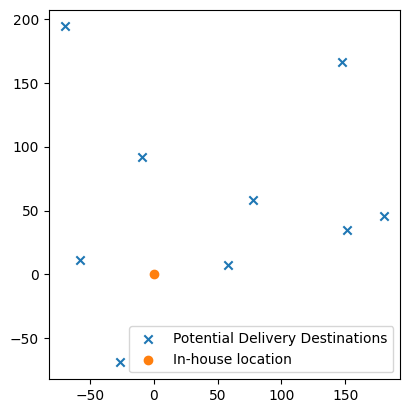

In [4]:
a = plt.subplot()
a.scatter(_K[1:,0], _K[1:,1], marker='x', label='Potential Delivery Destinations')
a.scatter(_K[0,0], _K[0,1], marker='o', label='In-house location')
a.legend()
a.set_aspect('equal')
plt.show()

荷物の重さの分布は次のようになる。

(array([ 0.,  0.,  0.,  1.,  1.,  7., 13., 12., 21., 14., 14.,  9.,  8.,
         4.,  6.,  4.,  1.,  4.,  0.,  0.]),
 array([   0.,  100.,  200.,  300.,  400.,  500.,  600.,  700.,  800.,
         900., 1000., 1100., 1200., 1300., 1400., 1500., 1600., 1700.,
        1800., 1900., 2000.]),
 <BarContainer object of 20 artists>)

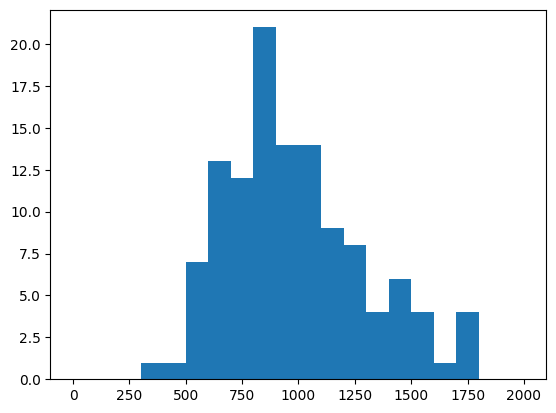

In [5]:
plt.hist(w, bins=20, range=(0,2000))

### 日ごとのスケジュールの列挙
どのような移動経路を通り、どの荷物を配送するかを日ごとに列挙する。<br>
ここでの方針としては、日付を問わず共通となる移動経路を列挙するし、その移動経路上で注文の配送を行うスケジュールを列挙する。

In [ ]:
# Docker環境とメモリ16Gのマシンではこの計算処理はリソースが足りない。
# 主な原因としては以下の通り
# 1. 大量の変数と制約の生成
# 2. 部分集合の全列挙
# 3. 並列処理のオーバーヘッド

def simulate_route(z):
    # enumerate_routes の中でのみ用いる関数
    # z は k_minus_o の部分集合を意味するは長さnum_places の 0 または1の値のリストで、
    # z[k] == 1 (k in K) が k への訪問があることを意味する．

    if z[0] == 0:  # 自社拠点を通らない移動経路は不適切なので None を返し，後段で除去する．
        return None

    # 巡回セールスマン問題を解く
    daily_route_prob = pulp.LpProblem(sense=pulp.LpMinimize)

    # k から l への移動の有無
    x = {
        (k, l): 
            pulp.LpVariable(f'x_{k}_{l}', cat='Binary') if k != l else pulp.LpAffineExpression()
        for k, l in product(K, K)
    }

    # MTZ 定式化のための補助変数
    u = {
        k: pulp.LpVariable(
            f'u_{k}', 
            lowBound=1, 
            upBound=len(K) - 1,
        )
        for k in K_minus_o
    }
    # MTZ 定式化の補助変数の説明では訪問順序であることを意識して u[0] を変数かのように書いたが，
    # 実際には 0 に固定されている値であるので，ここでは変数としては u[0] は定義しない．    

    h = pulp.LpVariable(f'h', lowBound=0, cat='Continuous')

    # 移動の構造
    for l in K:
        daily_route_prob += (
            pulp.lpSum([x[k,l] for k in K]) <= 1
        )

    for l in K:
        if z[l] == 1:
            # z で l への訪問が指定されている場合，必ず訪問するようにする．
            daily_route_prob += (
                pulp.lpSum([x[k,l] for k in K]) == 1
            )
            daily_route_prob += (
                pulp.lpSum([x[l,k] for k in K]) == 1
            )

        else:
            # z で l への訪問が禁止されている場合，訪問ができないように x に制約を入れる
            daily_route_prob += (
                pulp.lpSum([x[k,l] for k in K]) == 0
            )
            daily_route_prob += (
                pulp.lpSum([x[l,k] for k in K]) == 0                
            )
            

    # サイクルの除去．
    for k, l in product(K_minus_o, K_minus_o):
        daily_route_prob += (
            u[k] + 1 <= u[l] + len(K_minus_o) * (1 - x[k, l])
        )    

    # 労務関係．(巡回セールスマン問題にはない制約だが，これが満たされない場合実行不可能としたいので追加)
    travel = pulp.lpSum([t[k, l]*x[k, l] for k, l in product(K, K)]) # 移動時間
    daily_route_prob += (travel - H_regular <= h)
    daily_route_prob += (h <= H_max_overtime)

    # 目的関数
    daily_route_prob += travel
    daily_route_prob.solve()

    return {
        'z': z,
        'route': { # k から l への移動の有無を辞書で保持
            (k, l): x[k, l].value() 
            for k, l in product(K, K)
        },
        'optimal': daily_route_prob.status == 1,
        '移動時間': travel.value(),
        '残業時間': h.value(),
    }

def enumerate_routes():
    # 移動経路を列挙する    
    # joblib を用いて計算を並列化(16並列)して，K_minus_o のすべての部分集合に対する最短の移動経路を列挙
    # これは次のコードを並列化したもの．
    # routes = []
    # for z in product([0,1], repeat=len(K)):
    #     routes.append(simulate_route(z))
    routes = Parallel(n_jobs=16)(
        [delayed(simulate_route)(z) for z in product([0,1], repeat=len(K))]
    )
    
    # 結果が None のもの（自社拠点を通らないもの）を除去
    routes = pd.DataFrame(filter(lambda x: x is not None, routes))
    
    # 結果が Optimal でないもの（ここでは移動時間が長すぎて実行不能となるもの）を除去
    routes = routes[routes.optimal].copy()
    return routes

routes_df = enumerate_routes()

In [ ]:
routes_df